<a href="https://colab.research.google.com/github/FelixMaturano/SIS420-2025/blob/main/Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
from sklearn.linear_model import LogisticRegression
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

# Verificar si la GPU está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [4]:
# Transformaciones para las imágenes (compatible con ResNet18)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar CIFAR-10 (entrenamiento y prueba)
dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

# DataLoaders
loader = DataLoader(dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
# Modelo ResNet18
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model = model.to(device)
model.eval()

# Extraer características (entrenamiento)
features, labels = [], []
with torch.no_grad():
    for imgs, lbls in loader:
        imgs = imgs.to(device)
        out = model(imgs)
        out = out.view(out.size(0), -1)
        features.append(out.cpu().numpy())
        labels.append(lbls.numpy())

X = np.concatenate(features, axis=0)
y = np.concatenate(labels, axis=0).reshape(-1, 1)
data = np.hstack((X, y))
df = pd.DataFrame(data)
df.to_csv("cifar10_resnet18_features_train.csv", index=False)
print("✅ Características extraídas (entrenamiento)")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Características extraídas (entrenamiento)


In [15]:
# Extraer características (prueba)
test_features, test_labels = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        out = out.view(out.size(0), -1)
        test_features.append(out.cpu().numpy())
        test_labels.append(lbls.numpy())

X_test = np.concatenate(test_features, axis=0)
y_test = np.concatenate(test_labels, axis=0).reshape(-1, 1)
data_test = np.hstack((X_test, y_test))
df_test = pd.DataFrame(data_test)
df_test.to_csv("cifar10_resnet18_features_test.csv", index=False)
print("✅ Características extraídas (prueba)")

✅ Características extraídas (prueba)


In [16]:
# Cargar CSVs
train_df = pd.read_csv('cifar10_resnet18_features_train.csv')
test_df = pd.read_csv('cifar10_resnet18_features_test.csv')

# Separar características y etiquetas
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Dimensiones después de PCA: {X_train_pca.shape}, {X_test_pca.shape}")

Dimensiones después de PCA: (50000, 283), (10000, 283)


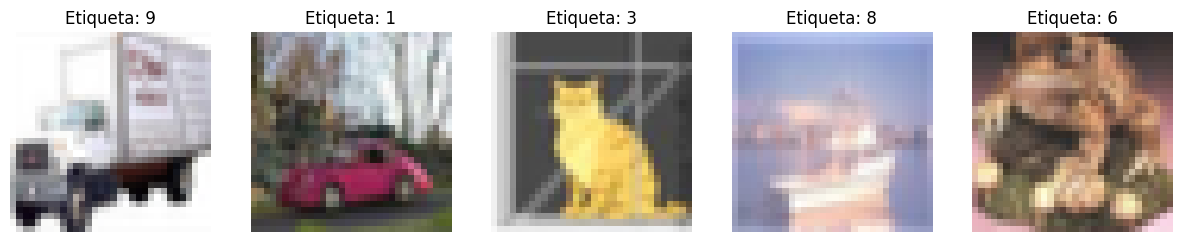

In [17]:
# Visualizar imágenes
cifar_data = CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=False)
indices = random.sample(range(len(X_train)), 5)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    img, _ = cifar_data[idx]
    img = img.permute(1, 2, 0).numpy()
    label = int(y_train[idx])
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Etiqueta: {label}")
    plt.axis('off')
plt.show()

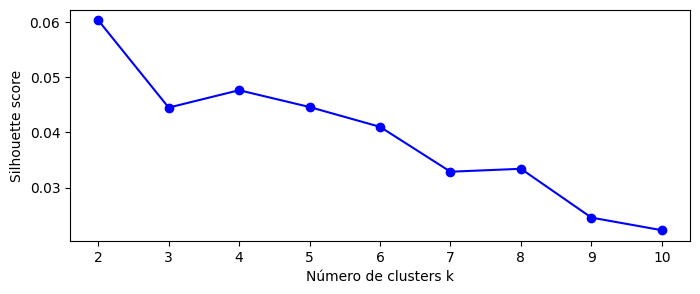

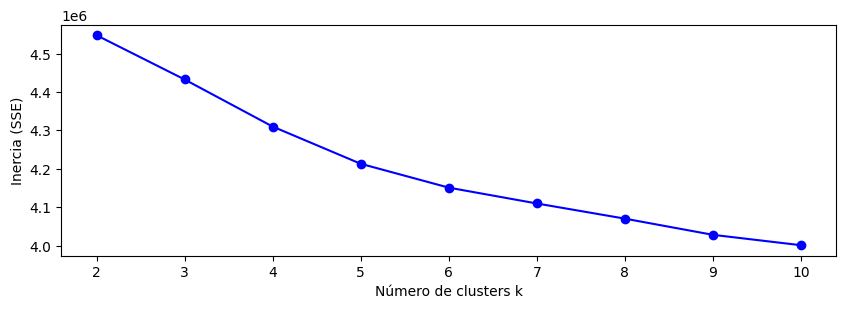

In [18]:
# Subconjunto para acelerar
subset_size = 10000
X_subset = X_train_pca[:subset_size]

# Calcular inercia y silhouette
inertia = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_subset)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_subset, kmeans.labels_))

# Visualizar
plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("Número de clusters k")
plt.ylabel("Silhouette score")
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(range(2, 11), inertia, "bo-")
plt.xlabel("Número de clusters k")
plt.ylabel("Inercia (SSE)")
plt.show()

In [19]:
# Entrenar regresión logística
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
start = time.time()
log_reg.fit(X_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento (regresión logística): {end - start:.2f} segundos")

# Evaluar precisión
accuracy = log_reg.score(X_test_pca, y_test)
print(f"Precisión regresión logística (etiquetas reales): {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Tiempo de entrenamiento (regresión logística): 19.24 segundos
Precisión regresión logística (etiquetas reales): 0.8665


In [22]:
from sklearn.metrics import silhouette_score, accuracy_score
# Definir k
k = 10

# Entrenar K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train_pca)

# Seleccionar imágenes representativas
idxs = np.argmin(X_digits_dist, axis=0)
y_representative_digits = y_train[idxs]  # Simular etiquetado manual

# Propagar etiquetas
y_train_propagated = y_representative_digits[kmeans.labels_]

# Evaluar precisión de etiquetas propagadas
accuracy_propagated = accuracy_score(y_train, y_train_propagated)
print(f"Precisión etiquetas propagadas (entrenamiento): {accuracy_propagated:.4f}")

Precisión etiquetas propagadas (entrenamiento): 0.6836


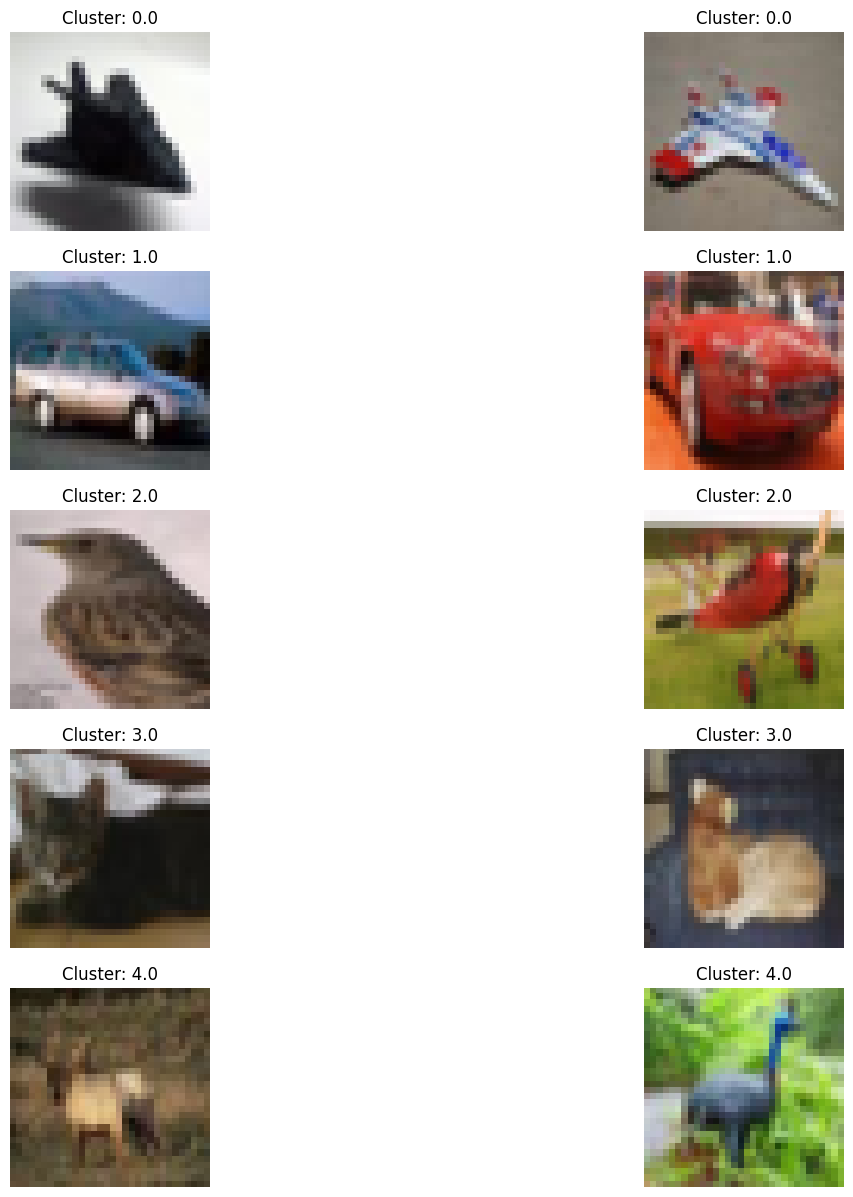

In [23]:
# Visualizar imágenes por clúster
clusters = np.unique(y_train_propagated)
plt.figure(figsize=(15, 15))
for i, cluster in enumerate(clusters[:5]):
    cluster_indices = np.where(y_train_propagated == cluster)[0][:2]
    for j, idx in enumerate(cluster_indices):
        img, _ = cifar_data[idx]
        img = img.permute(1, 2, 0).numpy()
        plt.subplot(5, 2, i*2 + j + 1)
        plt.imshow(img)
        plt.title(f'Cluster: {cluster}')
        plt.axis('off')
plt.show()

In [24]:
# Seleccionar imágenes de baja confianza
probas = log_reg.predict_proba(X_train_pca[:1000])
labels_ixs = np.argmax(probas, axis=1)
confidences = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])
sorted_ixs = np.argsort(confidences)
lowest_confidence_ixs = sorted_ixs[:k]

# Corregir etiquetas
y_train_corrected = y_train_propagated.copy()
y_train_corrected[lowest_confidence_ixs] = y_train[lowest_confidence_ixs]

# Reentrenar modelo
log_reg_active = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_active.fit(X_train_pca[:1000], y_train_corrected[:1000])

# Evaluar precisión
accuracy_active = log_reg_active.score(X_test_pca, y_test)
print(f"Precisión después de aprendizaje activo: {accuracy_active:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Precisión después de aprendizaje activo: 0.6589


In [25]:
# Mapear etiquetas
unique_labels = np.unique(y_train_corrected)
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
y_train_mapped = np.array([label_to_idx[label] for label in y_train_corrected])
y_test_mapped = np.array([label_to_idx.get(label, 0) for label in y_test])

# Convertir a tensores
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_mapped, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_mapped, dtype=torch.long).to(device)

# Dataset y DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Definir red neuronal
class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )
    def forward(self, x):
        return self.fc(x)

# Instanciar modelo
model = SimpleNN(X_train_pca.shape[1], len(unique_labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 3
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluación
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in zip(X_test_tensor.split(64), y_test_tensor.split(64)):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
print(f"Precisión red neuronal (etiquetas corregidas): {correct/total:.4f}")

Epoch 1/3, Loss: 0.0779
Epoch 2/3, Loss: 0.0531
Epoch 3/3, Loss: 0.0254
Precisión red neuronal (etiquetas corregidas): 0.6823
